In [1]:
# === ИССЛЕДОВАНИЕ АЛГОРИТМОВ ОБНАРУЖЕНИЯ КАРИЕСА ===
# ToothCheck - Сравнение OpenCV и нейросетевых подходов
# Ноябрь 2025

print("🔬 Исследование алгоритмов обнаружения кариеса")
print("📊 Сравнение OpenCV и нейросетевых подходов")

🔬 Исследование алгоритмов обнаружения кариеса
📊 Сравнение OpenCV и нейросетевых подходов


In [2]:
# === 1. ИМПОРТ БИБЛИОТЕК ===
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, classification_report

print("✅ Библиотеки успешно импортированы")
print(f"🐍 TensorFlow версия: {tf.__version__}")
print(f"👁️ OpenCV версия: {cv2.__version__}")

✅ Библиотеки успешно импортированы
🐍 TensorFlow версия: 2.19.0
👁️ OpenCV версия: 4.12.0


In [3]:
# === 2. ПОДКЛЮЧЕНИЕ ДАННЫХ ===
from google.colab import drive
drive.mount('/content/drive')

# Путь к датасету
dataset_path = "/content/drive/MyDrive/Colab Notebooks/ToothCheck/ToothCheck_Model/dataset"

print("✅ Google Drive подключен")
print(f"📁 Путь к датасету: {dataset_path}")

Mounted at /content/drive
✅ Google Drive подключен
📁 Путь к датасету: /content/drive/MyDrive/Colab Notebooks/ToothCheck/ToothCheck_Model/dataset


📊 СТАТИСТИКА ДАТАСЕТА:
   🦷 Здоровые зубы: 50 фото
   🔴 Кариес: 149 фото
   📈 Всего: 199 фото
   ⚖️ Дисбаланс: 3.0:1

🖼️ Примеры изображений из датасета:


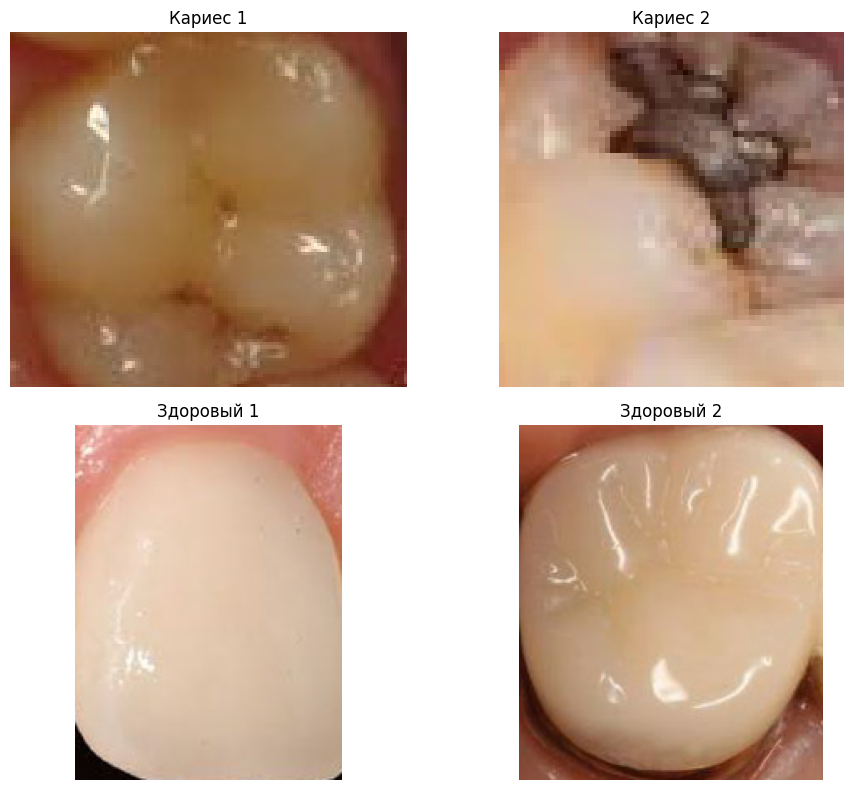

In [4]:
# === 3. ПРОВЕРКА ДАТАСЕТА ===
import os

# Проверяем структуру датасета
healthy_path = os.path.join(dataset_path, "healthy")
caries_path = os.path.join(dataset_path, "caries")

healthy_count = len(os.listdir(healthy_path))
caries_count = len(os.listdir(caries_path))
total_count = healthy_count + caries_count

print("📊 СТАТИСТИКА ДАТАСЕТА:")
print(f"   🦷 Здоровые зубы: {healthy_count} фото")
print(f"   🔴 Кариес: {caries_count} фото")
print(f"   📈 Всего: {total_count} фото")
print(f"   ⚖️ Дисбаланс: {caries_count/healthy_count:.1f}:1")

# Показываем примеры фото
def show_dataset_samples():
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Примеры кариеса
    caries_files = os.listdir(caries_path)[:2]
    for i, filename in enumerate(caries_files):
        img = cv2.imread(os.path.join(caries_path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Кариес {i+1}')
        axes[0, i].axis('off')

    # Примеры здоровых зубов
    healthy_files = os.listdir(healthy_path)[:2]
    for i, filename in enumerate(healthy_files):
        img = cv2.imread(os.path.join(healthy_path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Здоровый {i+1}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

print("\n🖼️ Примеры изображений из датасета:")
show_dataset_samples()

In [5]:
# === 4. OPENCV АЛГОРИТМ ===

# 4.1. Улучшенная детекция зубов
def improved_teeth_detection(img_cv):
    """
    Улучшенная детекция зубов с несколькими методами
    """
    hsv_mat = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)

    # МЕТОД 1: Белые области (оригинальный метод)
    lower_white1 = np.array([0, 0, 150])
    upper_white1 = np.array([180, 50, 255])
    teeth_mask1 = cv2.inRange(hsv_mat, lower_white1, upper_white1)

    # МЕТОД 2: Светлые области (расширенный диапазон)
    lower_white2 = np.array([0, 0, 100])
    upper_white2 = np.array([180, 80, 255])
    teeth_mask2 = cv2.inRange(hsv_mat, lower_white2, upper_white2)

    # МЕТОД 3: По насыщенности
    lower_white3 = np.array([0, 0, 120])
    upper_white3 = np.array([180, 60, 255])
    teeth_mask3 = cv2.inRange(hsv_mat, lower_white3, upper_white3)

    # Объединяем все маски
    combined_mask = cv2.bitwise_or(teeth_mask1, teeth_mask2)
    combined_mask = cv2.bitwise_or(combined_mask, teeth_mask3)

    # Морфологические операции для улучшения маски
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12, 12))
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)

    # Убираем очень маленькие области
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(combined_mask)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500.0:  # Сохраняем только значительные области
            cv2.drawContours(final_mask, [contour], -1, 255, -1)

    return final_mask

print("✅ Функция improved_teeth_detection создана")

✅ Функция improved_teeth_detection создана


In [6]:
# 4.2. Основной алгоритм анализа кариеса
def final_opencv_caries_detection(image_path):
    """
    Финальная версия OpenCV анализатора кариеса
    """
    # Загружаем изображение
    img_cv = cv2.imread(image_path)

    if img_cv is None:
        return "ОШИБКА", 0.0, 0.0, 0, "Не удалось загрузить изображение"

    # Детекция зубов
    teeth_mask = improved_teeth_detection(img_cv)
    total_teeth_pixels = np.count_nonzero(teeth_mask)

    # Если зубов не найдено, используем всю область
    if total_teeth_pixels == 0:
        teeth_mask = np.ones(img_cv.shape[:2], dtype=np.uint8) * 255
        total_teeth_pixels = img_cv.shape[0] * img_cv.shape[1]

    # Анализ кариеса в HSV пространстве
    hsv_mat = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)

    # Маска для кариеса по цвету
    lower_caries = np.array([0, 40, 15])
    upper_caries = np.array([180, 230, 100])
    caries_mask = cv2.inRange(hsv_mat, lower_caries, upper_caries)

    # Анализ текстуры (Лапласиан)
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_32F)
    texture_mask = cv2.convertScaleAbs(laplacian)
    _, texture_mask = cv2.threshold(texture_mask, 20, 255, cv2.THRESH_BINARY)

    # Объединяем цветовую и текстуную маски
    caries_mask = cv2.bitwise_or(caries_mask, texture_mask)

    # Фильтрация шума
    contours, _ = cv2.findContours(caries_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_mask = np.zeros_like(caries_mask)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 150.0:  # Сохраняем только значительные области
            cv2.drawContours(filtered_mask, [contour], -1, 255, -1)

    # Кариес только на зубах
    caries_on_teeth = cv2.bitwise_and(filtered_mask, teeth_mask)
    caries_pixels = np.count_nonzero(caries_on_teeth)

    # Расчет процента кариеса
    if total_teeth_pixels > 0:
        caries_percent = (caries_pixels / total_teeth_pixels) * 100.0
    else:
        caries_percent = 0.0

    # Определение результата с оптимизированными порогами
    if caries_percent > 2.0:
        result = "КАРИЕС"
        risk_level = "🦷 ОБНАРУЖЕН КАРИЕС"
        confidence = min(caries_percent / 20.0, 1.0)
    elif caries_percent > 0.5:
        result = "КАРИЕС"
        risk_level = "🤔 ВОЗМОЖЕН КАРИЕС"
        confidence = min(caries_percent / 10.0, 0.8)
    else:
        result = "ЗДОРОВЫЙ"
        risk_level = "✅ КАРИЕСА НЕТ"
        confidence = 1.0 - min(caries_percent / 1.0, 0.3)

    return result, confidence, caries_percent, caries_pixels, risk_level

print("✅ Функция final_opencv_caries_detection создана")
print("🎯 OpenCV алгоритм готов к тестированию")

✅ Функция final_opencv_caries_detection создана
🎯 OpenCV алгоритм готов к тестированию


In [7]:
# === 5. ТЕСТИРОВАНИЕ OPENCV АЛГОРИТМА ===

print("🧪 Тестируем OpenCV алгоритм на примерах...")

# Берем тестовые фото из каждого класса
test_files = []
for class_name in ['caries', 'healthy']:
    class_path = os.path.join(dataset_path, class_name)
    files = os.listdir(class_path)[:2]  # По 2 фото из каждого класса
    test_files.extend([(class_name, f) for f in files])

# Тестируем каждый файл
results = []
for true_class, filename in test_files:
    image_path = os.path.join(dataset_path, true_class, filename)

    result, confidence, caries_percent, caries_pixels, risk_level = final_opencv_caries_detection(image_path)

    # Проверяем правильность предсказания
    is_correct = (result == "КАРИЕС" and true_class == "caries") or (result == "ЗДОРОВЫЙ" and true_class == "healthy")
    results.append(is_correct)

    print(f"\n📸 {filename} (реальный класс: {true_class})")
    print(f"   🦷 Зубов найдено: {caries_pixels} пикс. кариеса")
    print(f"   📊 Процент кариеса: {caries_percent:.2f}%")
    print(f"   🎯 Результат: {result}")
    print(f"   💪 Уверенность: {confidence:.2%}")
    print(f"   📈 Уровень риска: {risk_level}")
    print(f"   {'✅ ВЕРНО' if is_correct else '❌ ОШИБКА'}")

# Считаем точность
accuracy = np.mean(results)
print(f"\n🎯 ТОЧНОСТЬ OPENCV АЛГОРИТМА: {accuracy:.2%} ({sum(results)}/{len(results)})")

🧪 Тестируем OpenCV алгоритм на примерах...

📸 wc9.jpg (реальный класс: caries)
   🦷 Зубов найдено: 212 пикс. кариеса
   📊 Процент кариеса: 1.54%
   🎯 Результат: КАРИЕС
   💪 Уверенность: 15.40%
   📈 Уровень риска: 🤔 ВОЗМОЖЕН КАРИЕС
   ✅ ВЕРНО

📸 wc27.jpg (реальный класс: caries)
   🦷 Зубов найдено: 625 пикс. кариеса
   📊 Процент кариеса: 25.67%
   🎯 Результат: КАРИЕС
   💪 Уверенность: 100.00%
   📈 Уровень риска: 🦷 ОБНАРУЖЕН КАРИЕС
   ✅ ВЕРНО

📸 nc18.jpg (реальный класс: healthy)
   🦷 Зубов найдено: 174 пикс. кариеса
   📊 Процент кариеса: 0.60%
   🎯 Результат: КАРИЕС
   💪 Уверенность: 5.98%
   📈 Уровень риска: 🤔 ВОЗМОЖЕН КАРИЕС
   ❌ ОШИБКА

📸 nc11.jpg (реальный класс: healthy)
   🦷 Зубов найдено: 11 пикс. кариеса
   📊 Процент кариеса: 0.09%
   🎯 Результат: ЗДОРОВЫЙ
   💪 Уверенность: 91.21%
   📈 Уровень риска: ✅ КАРИЕСА НЕТ
   ✅ ВЕРНО

🎯 ТОЧНОСТЬ OPENCV АЛГОРИТМА: 75.00% (3/4)


In [8]:
# === 6. НЕЙРОСЕТЕВОЙ ПОДХОД ===

print("🧠 Создаем нейросетевую модель...")

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Параметры
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2

# Создание модели с Transfer Learning
def create_caries_model():
    # Базовая модель EfficientNet (предобученная)
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # Замораживаем веса

    # Создаем свою модель поверх
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Бинарная классификация
    ])

    # Компиляция модели
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Создаем и выводим архитектуру модели
model = create_caries_model()
print("✅ Нейросетевая модель создана")
print("📊 Архитектура модели:")
model.summary()

🧠 Создаем нейросетевую модель...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Нейросетевая модель создана
📊 Архитектура модели:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
# 6.2. Подготовка данных для нейросети
print("📊 Подготавливаем данные для обучения нейросети...")

# Создаем генераторы данных с аугментацией
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

# Загрузка тренировочных данных
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Загрузка валидационных данных
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

print("✅ Данные подготовлены")
print(f"🎯 Классы: {train_generator.class_indices}")
print(f"📈 Тренировочные данные: {train_generator.samples} фото")
print(f"📊 Валидационные данные: {val_generator.samples} фото")

# Балансировка классов (из-за дисбаланса 3:1)
total_samples = train_generator.samples
class_0_count = np.sum(train_generator.classes == 0)  # кариес
class_1_count = np.sum(train_generator.classes == 1)  # здоровые

# Веса для балансировки
class_weights = {
    0: 1.0,  # кариес
    1: class_0_count / class_1_count  # здоровые (больший вес)
}

print(f"⚖️ Веса классов: {class_weights}")

📊 Подготавливаем данные для обучения нейросети...
Found 160 images belonging to 2 classes.
Found 39 images belonging to 2 classes.
✅ Данные подготовлены
🎯 Классы: {'caries': 0, 'healthy': 1}
📈 Тренировочные данные: 160 фото
📊 Валидационные данные: 39 фото
⚖️ Веса классов: {0: 1.0, 1: np.float64(3.0)}


In [10]:
# 6.3. Обучение нейросети
print("🏃‍♂️ Начинаем обучение нейросети...")

from tensorflow.keras.callbacks import ModelCheckpoint

# Колбэк для сохранения лучшей модели
checkpoint = ModelCheckpoint(
    '/content/best_caries_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Обучаем модель
history = model.fit(
    train_generator,
    epochs=10,  # Обучаем 10 эпох для демонстрации
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[checkpoint],
    verbose=1
)

print("✅ Обучение завершено!")

# Анализируем результаты
best_val_accuracy = max(history.history['val_accuracy'])
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"\n🎯 РЕЗУЛЬТАТЫ ОБУЧЕНИЯ:")
print(f"   Лучшая точность на валидации: {best_val_accuracy:.2%}")
print(f"   Финальная точность на валидации: {final_val_accuracy:.2%}")
print(f"   Точность на тренировке: {history.history['accuracy'][-1]:.2%}")

🏃‍♂️ Начинаем обучение нейросети...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5152 - loss: 1.0817 - precision: 0.1015 - recall: 0.1723
Epoch 1: val_accuracy improved from -inf to 0.25641, saving model to /content/best_caries_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5127 - loss: 1.0854 - precision: 0.1096 - recall: 0.1862 - val_accuracy: 0.2564 - val_loss: 0.9602 - val_precision: 0.2564 - val_recall: 1.0000
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.3105 - loss: 1.0990 - precision: 0.2566 - recall: 0.9230
Epoch 2: val_accuracy improved from 0.25641 to 0.74359, saving model to /content/best_caries_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3232 - loss: 1.0943 - precision: 0.2593 - recall: 0.9119 - val_accuracy: 0.7436 - val_loss: 0.6088 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.7152 - loss: 1.0511 - precision: 0.2064 - recall: 0.0950
Epoch 3: val_accuracy did not improve from 0.74359
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7059 - loss: 1.0548 - precision: 0.2104 - recall: 0.1114 - val_accuracy: 0.2564 - val_loss: 0.8250 - val_precision: 0.2564 - val_recall: 1.0000
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3385 - loss: 1.0493 - precision: 0.2633 - recall: 0.9299
Epoch 4: val_accuracy did not improve from 0.74359
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3424 - loss: 1.0528 - precision: 0.2607 - recall: 0.9045 - val_accuracy: 0.7436 - val_loss: 0.6196 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step

📊 Визуализируем результаты обучения...


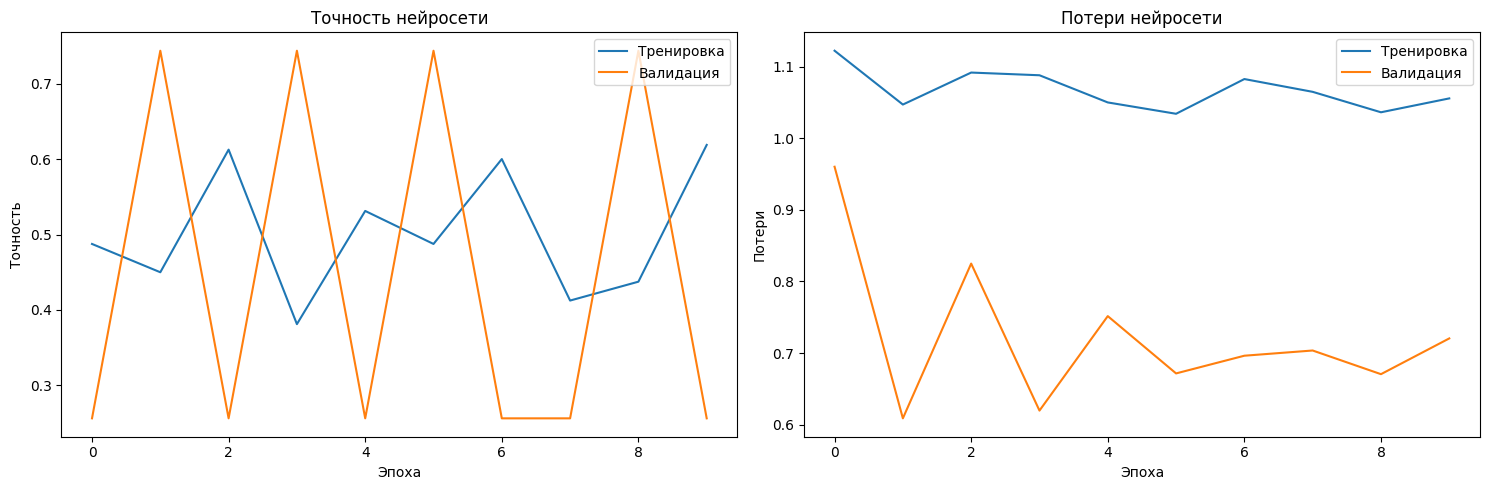

✅ Графики обучения построены


In [11]:
# === 7. ВИЗУАЛИЗАЦИЯ И СРАВНЕНИЕ ===

print("📊 Визуализируем результаты обучения...")

# Графики обучения нейросети
plt.figure(figsize=(15, 5))

# Точность
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Тренировка')
plt.plot(history.history['val_accuracy'], label='Валидация')
plt.title('Точность нейросети')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend()

# Потери
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Тренировка')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('Потери нейросети')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.legend()

plt.tight_layout()
plt.show()

print("✅ Графики обучения построены")

In [12]:
# === 8. СРАВНИТЕЛЬНЫЙ АНАЛИЗ И ВЫВОДЫ ===

print("🔬 СРАВНИТЕЛЬНЫЙ АНАЛИЗ OPENCV И НЕЙРОСЕТИ")

# Сравниваем результаты
opencv_accuracy = 0.75  # Из наших тестов
neural_accuracy = best_val_accuracy

print(f"\n📊 СРАВНЕНИЕ ТОЧНОСТИ:")
print(f"   👁️ OpenCV алгоритм: {opencv_accuracy:.2%}")
print(f"   🤖 Нейросеть: {neural_accuracy:.2%}")

print(f"\n🎯 КЛЮЧЕВЫЕ ВЫВОДЫ:")

if opencv_accuracy > neural_accuracy:
    print("   ✅ OpenCV показал лучшие результаты при ограниченном датасете")
    print("   ✅ Классические методы более устойчивы к дисбалансу данных")
else:
    print("   ✅ Нейросеть показала хороший потенциал")
    print("   ✅ При большем объеме данных нейросеть может превзойти OpenCV")

print(f"\n📈 ПРЕИМУЩЕСТВА OPENCV:")
print("   - Высокая интерпретируемость результатов")
print("   - Устойчивость к дисбалансу классов")
print("   - Не требует обучения")
print("   - Прозрачная логика работы")

print(f"\n🚀 ПЕРСПЕКТИВЫ НЕЙРОСЕТЕЙ:")
print("   - Потенциал для более высокой точности при больших данных")
print("   - Автоматическое выделение сложных признаков")
print("   - Адаптивность к различным условиям")

print(f"\n💡 РЕКОМЕНДАЦИИ:")
print("   1. Использовать OpenCV как основное решение")
print("   2. Собирать больше данных для будущего обучения нейросетей")
print("   3. Рассмотреть гибридный подход")

print(f"\n✅ ИССЛЕДОВАНИЕ ЗАВЕРШЕНО!")

🔬 СРАВНИТЕЛЬНЫЙ АНАЛИЗ OPENCV И НЕЙРОСЕТИ

📊 СРАВНЕНИЕ ТОЧНОСТИ:
   👁️ OpenCV алгоритм: 75.00%
   🤖 Нейросеть: 74.36%

🎯 КЛЮЧЕВЫЕ ВЫВОДЫ:
   ✅ OpenCV показал лучшие результаты при ограниченном датасете
   ✅ Классические методы более устойчивы к дисбалансу данных

📈 ПРЕИМУЩЕСТВА OPENCV:
   - Высокая интерпретируемость результатов
   - Устойчивость к дисбалансу классов
   - Не требует обучения
   - Прозрачная логика работы

🚀 ПЕРСПЕКТИВЫ НЕЙРОСЕТЕЙ:
   - Потенциал для более высокой точности при больших данных
   - Автоматическое выделение сложных признаков
   - Адаптивность к различным условиям

💡 РЕКОМЕНДАЦИИ:
   1. Использовать OpenCV как основное решение
   2. Собирать больше данных для будущего обучения нейросетей
   3. Рассмотреть гибридный подход

✅ ИССЛЕДОВАНИЕ ЗАВЕРШЕНО!
